In [13]:
import fit_classes as fp
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy import optimize

errors = []
ERROR = 2 # Error in mV

class DataPlus(fp.Data):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        def sinus_model(params, x):
            A,f,phi,c = params
            return A*np.sin(2*np.pi*f*x + phi) + c
        
        file = os.path.join(os.path.abspath(os.getcwd()), "data", "params.txt")
        name = str(self.name).split("\\")[-1]
        var = None
        vals = []
        with open(file, "r") as file:
            for line in file:
                vals.append((
                    line.strip().split(": ")[0],
                     tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))
                    ))

        check = False
        for var in vals:
            if var[0] == name:
                A, f, phi, c = var[1]
                check = True
                
        if check == False:
            A, f, phi, c = 100, 0.006, -13.06097, 25
            A = (np.abs(max(self.y)) + np.abs(min(self.y)))/2
            c = (max(self.y) + min(self.y))/2

            f_interp = interp1d(self.x, self.y, kind='cubic')
            x_dense = np.linspace(self.x.min(), self.x.max(), 1000)
            y_dense = f_interp(x_dense)

            crossings = []
            for i in range(len(x_dense)-1):
                if (y_dense[i] - c) * (y_dense[i+1] - c) < 0:  # Sign change
                    # Refine crossing with brentq
                    root = optimize.brentq(lambda x_val: f_interp(x_val) - c, x_dense[i], x_dense[i+1])
                    crossings.append(root)
                    # punt
                    # if self.x[list(self.x).index(punt) - 5] > self.x[list(self.x).index(punt) + 5]:
                    #     dalende_root.append(punt)

            
            # Find descending zero-crossings
            stijgende_root = []
            for i in range(len(self.y) - 2):
                if (self.y[i - 1] + self.y[i - 2])/2 < c and (self.y[i + 1] + self.y[i + 2])/2 >= c and self.x[i] > 10:
                    if stijgende_root != []:
                        if self.x[i] - stijgende_root[-1] > 10:
                            stijgende_root.append(self.x[i])
                    else:
                        stijgende_root.append(self.x[i])
            
            crossing_count = len(crossings)
            # crossing_count = crossing_count if crossing_count < 30 else 30
            # f = 0.00101048 if abs(len(crossings) - 21) < abs(len(crossings) - 42) else 0.00239959
            f = 0.003
            # phi  = -(stijgende_root[0]*f)*2*np.pi
            phi = 0
            # A = 8

        # phi = np.arcsin(self.x[0] / A)

        FIT_POINTS = 400
        SKIP_POINTS = 1

        self.x = self.x[:FIT_POINTS][::SKIP_POINTS]
        self.y = self.y[:FIT_POINTS][::SKIP_POINTS]
        self.dx = self.dx[:FIT_POINTS][::SKIP_POINTS]
        self.dy = self.dy[:FIT_POINTS][::SKIP_POINTS]

        self.fit = self.fit(sinus_model, initial_guess=(A, f, phi, c))
        self.fit.init = A, f, phi, c

        if check == False:
            file = os.path.join(os.path.abspath(os.getcwd()), "data", "params.txt")
            if self.fit.chi2_red < 10:
                values = (float(A), float(f), float(phi), float(c))
                with open(file, "a") as file:
                    file.write(f"{name}: {values}\n")


        self.A, self.f, self.phi, self.c = self.fit.minima

def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    data = np.genfromtxt(file_path, delimiter=",", skip_header=9)
    x = data[:, 0].astype(int)
    y = data[:, 1]
    mask = np.concatenate(([True], y[1:] != y[:-1]))
    x = x[mask]
    y = y[mask]

    dy = ERROR*np.ones_like(y)
    return DataPlus(x, y, dy, name=file_path)
        
def get_lowest_folders(root):
    lowest_folders = []
    for dirpath, dirnames, filenames in os.walk(root):
        if not dirnames:
            lowest_folders.append(dirpath)
    return lowest_folders

def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    for folder in get_lowest_folders(root):
        total_files += len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

    current_file = 0
    for folder in get_lowest_folders(root):
        folder_name = os.path.basename(folder)
        data_list = []
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):
                current_file += 1
                # os.system(f'echo "File: {current_file:>3}/{total_files}"')
                data_list.append(data_from_file(file_path))
        
        if data_list:
            folder_data[folder_name] = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


# # print(data_arrays['opgave1'][0].show())
# print(f"{data_arrays['opgave1'][0].fit}")
# print(f"{data_arrays['opgave1'][0].f}")
# # print(f"{data_arrays['opgave1'][0].A}")
# # print(f"{data_arrays['opgave1'][0].w}")
# data_arrays['opgave1'][0].fit.show(size=2, fit_guess=True)
# print(f"{data_arrays['opgave5_freq2'][13].fit}")
# print(f"{data_arrays['opgave5_freq2'][13].f}")
# print(str(data_arrays['2000Hz_26_1cm'][27].name).split('\\')[-1])
# data_arrays['2000Hz_26_1cm'][27].fit.show(size=2, fit_guess=True)
# print((data_arrays['2000Hz_44_1cm'][10].name).split('\\')[-1])
# data_arrays['2000Hz_44_1cm'][10].fit.show(size=2, fit_guess=True)
# print((data_arrays['2000Hz_44_1cm'][4].name).split('\\')[-1])
# data_arrays['2000Hz_44_1cm'][4].fit.show(size=2, fit_guess=True)



In [85]:
file = os.path.join(os.path.abspath(os.getcwd()), "data", "table.txt")
with open(file, "w") as file:
    file.write(r'''
    \begin{table}[h!]
    \captionof{table}{Deze tabel bevat al de fitparameters en fitwaarden voor al de gefitte datasets.}
    \label{tab:fits}
    \centering
    \begin{tabular}{|c|c|c|c|c|c|c|}
    \hline
    filename & $A_0$ (mV) & f (mHz) & $\phi$ (rads) & c (mV) & $\chi^2_{red}$ & p-waarde \\
    \hline
    ''')
    n = 0
    for key in data_arrays:
        for i in range(len(data_arrays[key])):
            if n == 25 or ( (n - 25) % 48 == 0 and n != 22):
                file.write(r'''\hline
    \end{tabular}
    \end{table}
    \begin{table}[h!]
    \centering
    \begin{tabular}{|c|c|c|c|c|c|c|}
    \hline
    filename & $A_0$ (mV) & f (mHz) & $\phi$ (rads) & c (mV) & $\chi^2_{red}$ & p-waarde \\
    \hline
    ''')
            name = str(data_arrays[key][i].name).split('\\')[-1].replace('_', r'\_')
            file.write(f'{name} & {data_arrays[key][i].A:.3f}' + r'$\pm$' +f'{data_arrays[key][i].fit.minima_errors[0][0]:.3f} & {data_arrays[key][i].f*1000:.3f}' + r'$\pm$' +f'{data_arrays[key][i].fit.minima_errors[1][0]:.3f} & {data_arrays[key][i].phi:.3f}' + r'$\pm$' +f'{data_arrays[key][i].fit.minima_errors[2][0]:.3f} & {data_arrays[key][i].c:.3f}' + r'$\pm$' +f'{data_arrays[key][i].fit.minima_errors[3][0]:.3f} & {data_arrays[key][i].fit.chi2_red:.3f} & {data_arrays[key][i].fit.p_value:.3f}' + '\\\\\n\t')
            n += 1
    file.write(r'''\hline
    \end{tabular}
    \end{table}
    ''')

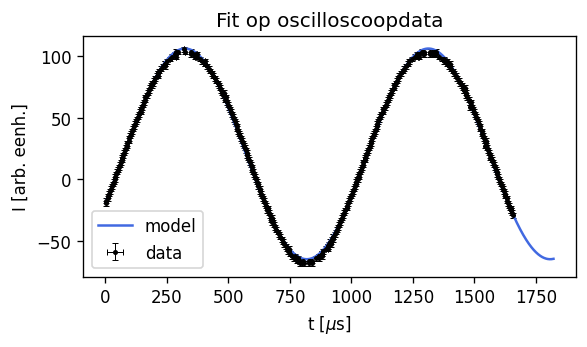

In [15]:
# # # CAREFULL: THIS DISPLAYS 213 FITS!!!
# for key in data_arrays:
#     for i in range(len(data_arrays[key])):
#         print(key, i)
#         print("chi2_red:", data_arrays[key][i].fit.chi2_red)
#         print("minima:", data_arrays[key][i].fit.minima)
#         data_arrays[key][i].fit.show(size=2, fit_guess=True)

# for key in ['2000Hz_26_1cm']:
#     for i in range(len(data_arrays[key])):
#         print(key, i)
#         print("name:", data_arrays[key][i].name)
#         print("chi2_red:", data_arrays[key][i].fit.chi2_red)
#         print("minima:", data_arrays[key][i].fit.minima)
#         data_arrays[key][i].fit.show(size=2, fit_guess=True)
data_arrays['opgave1'][0].fit.show(size=2, title="Fit op oscilloscoopdata", x_label="t [$\mu$s]", y_label="I [arb. eenh.]")

----------------------------------------------------------------------------------------------------------------
opgave2_1
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    131.78433 \pm      1.84293 $
For parameter f        :     $      0.01540 \pm      0.00011 $
For parameter phi      :     $      1.28786 \pm      0.01417 $
For parameter c        :     $      4.77553 \pm      1.31172 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          53.52623866
Reduced χ² value       :     χ²_red           1.84573237
P-value                :     p-value          0.00366630
----------------------------------------------------------------------------------------------------------------



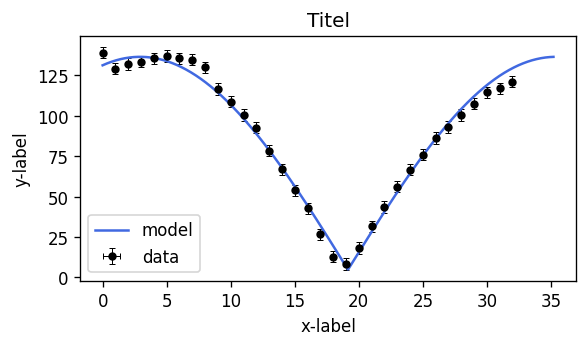

----------------------------------------------------------------------------------------------------------------
opgave2_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    167.52016 \pm      2.20701 $
For parameter f        :     $      0.02943 \pm      0.00010 $
For parameter phi      :     $      1.26834 \pm      0.01350 $
For parameter c        :     $      2.97315 \pm      1.57926 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          38.30514554
Reduced χ² value       :     χ²_red           1.23564986
P-value                :     p-value          0.17188177
----------------------------------------------------------------------------------------------------------------



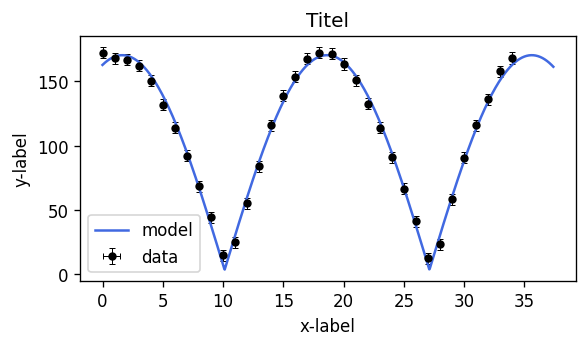

----------------------------------------------------------------------------------------------------------------
opgave2_3
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    150.41803 \pm      2.03857 $
For parameter f        :     $      0.04403 \pm      0.00011 $
For parameter phi      :     $      1.23655 \pm      0.01384 $
For parameter c        :     $      8.99631 \pm      1.45627 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          23.51825356
Reduced χ² value       :     χ²_red           0.75865334
P-value                :     p-value          0.82969921
----------------------------------------------------------------------------------------------------------------



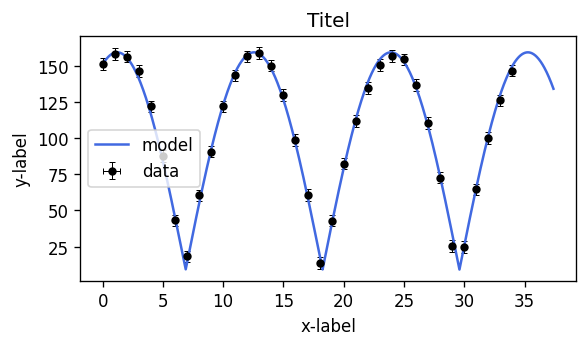

----------------------------------------------------------------------------------------------------------------
opgave4_freq1
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     91.56032 \pm      1.82292 $
For parameter f        :     $      0.02471 \pm      0.00028 $
For parameter phi      :     $      1.55506 \pm      0.01874 $
For parameter c        :     $      4.02978 \pm      1.24949 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          11.45421563
Reduced χ² value       :     χ²_red           0.76361438
P-value                :     p-value          0.71978175
----------------------------------------------------------------------------------------------------------------



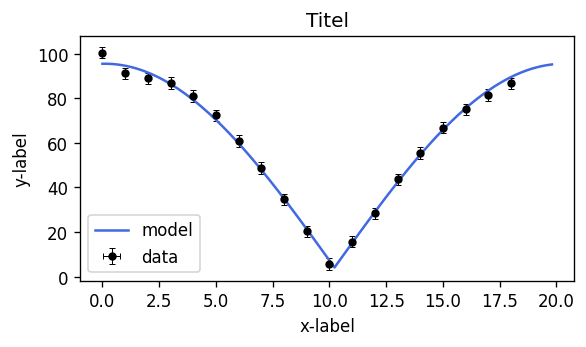

----------------------------------------------------------------------------------------------------------------
opgave4_freq2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    120.11785 \pm      2.25874 $
For parameter f        :     $      0.05088 \pm      0.00026 $
For parameter phi      :     $      1.42206 \pm      0.01837 $
For parameter c        :     $     -3.58585 \pm      1.57827 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         131.63916152
Reduced χ² value       :     χ²_red           8.77594410
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



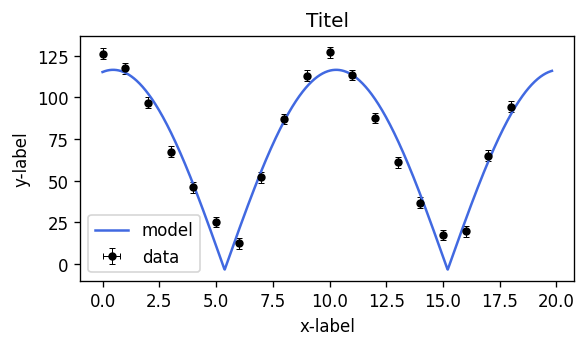

----------------------------------------------------------------------------------------------------------------
opgave5_freq1
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     60.22594 \pm      1.07382 $
For parameter f        :     $      0.02727_{-     0.00028}^{+   0.00044} $
For parameter phi      :     $      1.43376_{-     0.01843}^{+   0.03015} $
For parameter c        :     $      2.45967 \pm      0.77174 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min           6.94016405
Reduced χ² value       :     χ²_red           0.46267760
P-value                :     p-value          0.95928890
----------------------------------------------------------------------------------------------------------------



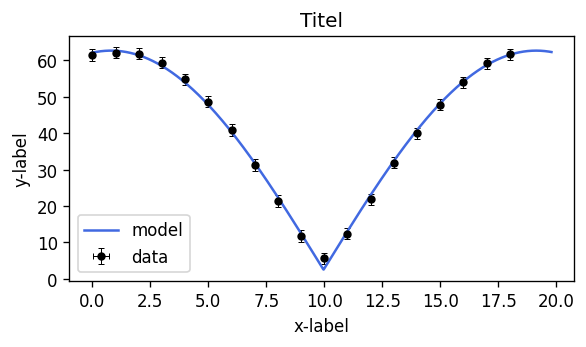

----------------------------------------------------------------------------------------------------------------
opgave5_freq2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    262.17251 \pm      4.75491 $
For parameter f        :     $      0.05270 \pm      0.00025 $
For parameter phi      :     $      1.22078 \pm      0.01815 $
For parameter c        :     $      7.11167 \pm      3.36336 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min           6.86301170
Reduced χ² value       :     χ²_red           0.45753411
P-value                :     p-value          0.96134009
----------------------------------------------------------------------------------------------------------------



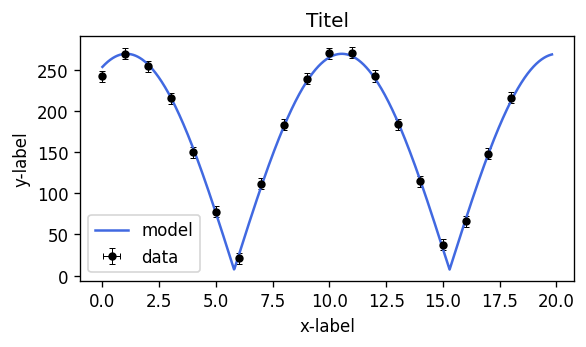

----------------------------------------------------------------------------------------------------------------
opgave5_freq3
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     88.59592 \pm      1.64317 $
For parameter f        :     $      0.07644 \pm      0.00026 $
For parameter phi      :     $      1.37373 \pm      0.01831 $
For parameter c        :     $     -2.82103 \pm      1.15433 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         100.40117457
Reduced χ² value       :     χ²_red           6.69341164
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



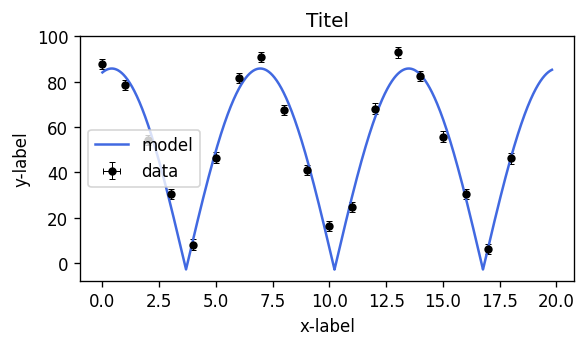

----------------------------------------------------------------------------------------------------------------
2000Hz_26_1cm
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     89.18552 \pm      1.46080 $
For parameter f        :     $      0.04693 \pm      0.00014 $
For parameter phi      :     $      1.62686 \pm      0.01565 $
For parameter c        :     $     -1.89395 \pm      1.00921 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         649.31640876
Reduced χ² value       :     χ²_red          24.97370803
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



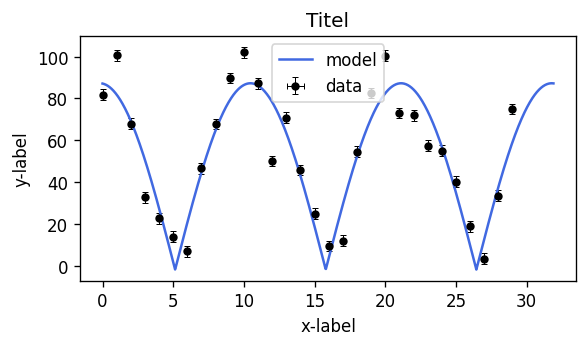

----------------------------------------------------------------------------------------------------------------
2000Hz_35_0cm
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     82.07182 \pm      1.33150 $
For parameter f        :     $      0.06318 \pm      0.00014 $
For parameter phi      :     $      1.24282 \pm      0.01614 $
For parameter c        :     $      1.46498 \pm      0.93893 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         475.21502391
Reduced χ² value       :     χ²_red          17.60055644
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



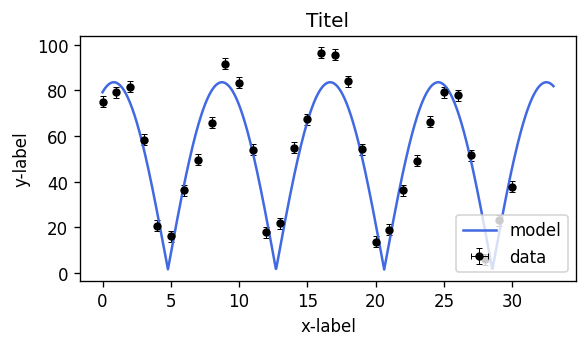

----------------------------------------------------------------------------------------------------------------
2000Hz_44_1cm
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     81.53054 \pm      1.28634 $
For parameter f        :     $      0.08081 \pm      0.00014 $
For parameter phi      :     $      1.28506 \pm      0.01579 $
For parameter c        :     $     -1.18748 \pm      0.91005 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         245.37928719
Reduced χ² value       :     χ²_red           9.08812175
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



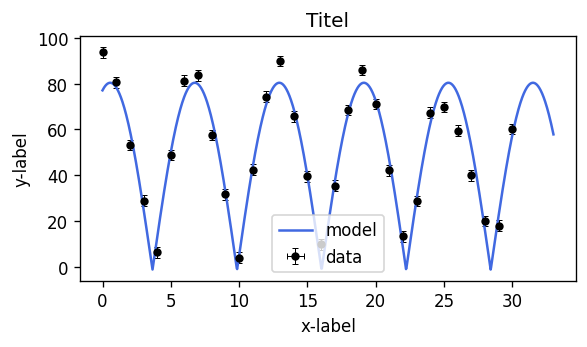

In [16]:
def sinus_model_abs(params, x):
    A,f,phi,c = params
    return np.abs(A*np.sin(2*np.pi*f*x + phi)) + c

names = ['opgave2_1', 'opgave2_2', 'opgave2_3', 'opgave4_freq1', 'opgave4_freq2', 'opgave5_freq1', 'opgave5_freq2', 'opgave5_freq3', '2000Hz_26_1cm', '2000Hz_35_0cm', '2000Hz_44_1cm' ]
freqs = [0.013, 0.028, 0.04, 0.03, 0.05, 0.025, 0.05, 0.075, 0.05, 0.06, 0.075]
for file, f in zip(names, freqs):
    x = [i for i in range(len(data_arrays[file]))]
    y = [data_arrays[file][i].A for i in range(len(data_arrays[file]))]
    dy = np.ones_like(y)*0.025*max(y)
    opgave2_1_A = fp.Data(x, y, dy)
    A = max(y)
    phi = np.pi/2
    c = 0
    fitting = opgave2_1_A.fit(sinus_model_abs, initial_guess=(A, f, phi, c))
    print("----------------------------------------------------------------------------------------------------------------")
    print(file)
    print(fitting)
    # fitting.init = A, f, phi, c
    # fitting.show(fit_guess=True)
    fitting.show()